In [ ]:
!pip install imageio tqdm
!apt install -y libgl1-mesa-glx


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!wget --no-check-certificate 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip'
!unzip -q data_road.zip

--2025-07-24 12:43:11--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.11, 52.219.75.147, 3.5.134.15, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip       100%[===================>] 449.17M  19.7MB/s    in 24s     

2025-07-24 12:43:36 (19.0 MB/s) - ‘data_road.zip’ saved [470992343/470992343]



In [ ]:
import numpy as np
import os
import random
import re
import cv2
import imageio
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Semente para reprodutibilidade
random.seed(100)
np.random.seed(100)

# Diretórios do dataset KITTI Road
image_data_folder = 'data_road/training/image_2/'
mask_data_folder = 'data_road/training/gt_image_2/'
test_dir = 'data_road/testing/image_2/'
test_predict_dir = 'test_predict/'

os.makedirs(test_predict_dir, exist_ok=True)

# Carregar nomes dos arquivos de imagem e máscara
all_images = sorted(os.listdir(image_data_folder))
all_images = np.array(all_images)

all_mask_images = {img: re.sub('_', '_road_', img) for img in all_images}

test_images = sorted(os.listdir(test_dir))
test_images = np.array(test_images)

# Dimensões da imagem e parâmetros
width = 1280
height = 384
batch_size = 2

train_images = all_images[:232]
valid_images = all_images[232:]
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(valid_images) // batch_size

In [ ]:
# Gerador de batches para treinamento
def batch_generator(images, batch_size):
    while True:
        ix = np.random.choice(np.arange(images.shape[0]), batch_size)
        batch_features = np.zeros((batch_size, height, width, 3), dtype='float32')
        batch_labels = np.zeros((batch_size, height, width, 1), dtype='float32')

        for index, i in enumerate(ix):
            original_img = load_img(image_data_folder + images[i])
            img_array = img_to_array(original_img)
            resized_img = cv2.resize(img_array, (width, height))
            batch_features[index] = resized_img / 255.0

            mask_img = load_img(mask_data_folder + all_mask_images[images[i]])
            mask_array = img_to_array(mask_img)
            resized_mask = cv2.resize(mask_array, (width, height))
            batch_labels[index, :, :, 0] = resized_mask[:, :, 2] / 255.0  # canal vermelho indica estrada

        yield batch_features, batch_labels

# Blocos da U-Net
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters = int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [ ]:
# Construção do modelo
filters = 64
input_layer = Input(shape=(height, width, 3))
residuals = []

d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2
d3, res3 = down(d2, filters)
residuals.append(res3)

filters += 32
d4, res4 = down(d3, filters)
residuals.append(res4)

d5, res5 = down(d4, filters)
residuals.append(res5)

d6, res6 = down(d5, filters)
residuals.append(res6)

d7, res7 = down(d6, filters)
residuals.append(res7)

d8 = down(d7, filters, pool=False)

up1 = up(d8, residual=residuals[-1], filters=filters/2)
up2 = up(up1, residual=residuals[-2], filters=filters/2)
up3 = up(up2, residual=residuals[-3], filters=filters/2)
up4 = up(up3, residual=residuals[-4], filters=filters/2)
up5 = up(up4, residual=residuals[-5], filters=filters/2)
filters /= 2
up6 = up(up5, residual=residuals[-6], filters=filters/2)
filters /= 2
up7 = up(up6, residual=residuals[-7], filters=filters/2)

output_layer = Conv2D(1, (1, 1), activation='sigmoid')(up7)
model = Model(input_layer, output_layer)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 1280, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 384, 1280, │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 384, 1280, │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 192, 640,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 192, 640,  │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 192, 640,  │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 96, 320,   │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 96, 320,   │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 96, 320,   │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 48, 160,   │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 48, 160,   │    663,840 │ max_pooling2d_9[… │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 48, 160,   │    746,784 │ conv2d_44[0][0]   │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 24, 80,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 24, 80,    │    746,784 │ max_pooling2d_10… │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 24, 80,    │    746,784 │ conv2d_46[0][0]   │
│                     │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 12, 40,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 288)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 12, 40,    │    746,784 │ max_pooling2d_11

 Total params: 12,993,657 (49.57 MB)

 Trainable params: 12,993,657 (49.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Dice Coefficient
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    intersection = tf.reduce_sum(y_true * y_pred)
    return 2 * intersection / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Callbacks e compilação
kfold_weights_path = 'best_model.weights.h5'
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)]

In [ ]:
# Fases de treino com diferentes learning rates
for lr, epochs in zip([5e-4, 2e-4, 1e-4, 5e-5, 1e-5, 5e-6, 5e-6], [1, 1, 10, 5, 5, 5, 10]):
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=[dice_coef])
    model.fit(batch_generator(train_images, batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=epochs,
              validation_data=batch_generator(valid_images, batch_size),
              validation_steps=validation_steps,
              callbacks=callbacks,
              verbose=1)

model.save_weights('weights_final.weights.h5')


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - dice_coef: 0.1172 - loss: 0.4733

116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 316ms/step - dice_coef: 0.1197 - loss: 0.4719 - val_dice_coef: 0.7153 - val_loss: 0.1831
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - dice_coef: 0.8749 - loss: 0.1307

116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 320ms/step - dice_coef: 0.8750 - loss: 0.1306 - val_dice_coef: 0.7805 - val_loss: 0.1516
Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9060 - loss: 0.0935

116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - dice_coef: 0.9060 - loss: 0.0935 - val_dice_coef: 0.7977 - val_loss: 0.1422
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9126 - loss: 0.0841

116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - dice_coef: 0.9126 - loss: 0.0841 - val_dice_coef: 0.7983 - val_loss: 0.1243
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - dice_coef: 0.8932 - loss: 0.0937 - val_dice_coef: 0.7764 - val_loss: 0.1408
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - dice_coef: 0.8967 - loss: 0.0918 - val_dice_coef: 0.8073 - val_loss: 0.1433
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9240 - loss: 0.0714

116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step - dice_coef: 0.9240 - loss: 0.0714 - val_dice_coef: 0.8594 - val_loss: 0.0949
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - dice_coef: 0.9288 - loss: 0.0697 - val_dice_coef: 0.8584 - val_loss: 0.1064
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.9416 - loss: 0.0553

116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - dice_coef: 0.9416 - loss: 0.0553 - val_dice_coef: 0.8605 - val_loss: 0.0902
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9425 - loss: 0.0536

116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - dice_coef: 0.9425 - loss: 0.0536 - val_dice_coef: 0.8876 - val_loss: 0.0837
Epoch 9/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - dice_coef: 0.9540 - loss: 0.0452 - val_dice_coef: 0.7993 - val_loss: 0.1151
Epoch 10/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9486 - loss: 0.0474

116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - dice_coef: 0.9486 - loss: 0.0474 - val_dice_coef: 0.9097 - val_loss: 0.0745
Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 308ms/step - dice_coef: 0.9534 - loss: 0.0456 - val_dice_coef: 0.8875 - val_loss: 0.0820
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - dice_coef: 0.9571 - loss: 0.0429 - val_dice_coef: 0.8385 - val_loss: 0.1267
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - dice_coef: 0.9596 - loss: 0.0367 - val_dice_coef: 0.8723 - val_loss: 0.1147
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - dice_coef: 0.9605 - loss: 0.0375 - val_dice_coef: 0.9011 - val_loss: 0.0818
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - dice_coef: 0.9539 - loss: 0.0398 - val_dice_coef: 0.8921 - val_loss: 0.0917
Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - dice_coef: 0.9644 - loss: 0.0342

116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 312ms/step - dice_coef: 0.9644 - loss: 0.0342 - val_dice_coef: 0.9029 - val_loss: 0.0725
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step - dice_coef: 0.9683 - loss: 0.0318 - val_dice_coef: 0.8603 - val_loss: 0.0969
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - dice_coef: 0.9697 - loss: 0.0279 - val_dice_coef: 0.8835 - val_loss: 0.1022
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - dice_coef: 0.9691 - loss: 0.0292 - val_dice_coef: 0.9002 - val_loss: 0.0871
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 294ms/step - dice_coef: 0.9718 - loss: 0.0260 - val_dice_coef: 0.8527 - val_loss: 0.1250
Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_coef: 0.9711 - loss: 0.0256

116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - dice_coef: 0.9711 - loss: 0.0256 - val_dice_coef: 0.9193 - val_loss: 0.0658
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - dice_coef: 0.9719 - loss: 0.0256 - val_dice_coef: 0.8766 - val_loss: 0.1010
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - dice_coef: 0.9737 - loss: 0.0229 - val_dice_coef: 0.8974 - val_loss: 0.0856
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - dice_coef: 0.9711 - loss: 0.0258 - val_dice_coef: 0.9109 - val_loss: 0.0773
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - dice_coef: 0.9760 - loss: 0.0215 - val_dice_coef: 0.8782 - val_loss: 0.1279
Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - dice_coef: 0.9736 - loss: 0.0217 - val_dice_coef: 0.8797 - val_loss: 0.1244
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 294ms/step - dice_coef: 0.9735 - loss: 0.0225 - val_dice_coef: 0.8944 - val_loss: 0.1139
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - dice_coef: 0.9746 - loss: 0

In [ ]:
# Funções para salvar predições
def write_to_pngfiles(batch_labels, images, istart, iend):
    for i in range(istart, iend):
        img_array = batch_labels[i - istart, :, :, 0] * 255
        img = Image.fromarray(img_array.astype(np.uint8))
        img_path = test_predict_dir + images[i][:-4] + '.png'
        img.save(img_path)

def write_to_jpgfiles(batch_features, batch_labels, images, istart, iend):
    for i in range(istart, iend):
        img_array = batch_features[i - istart, :, :, :].copy()
        img_array[:, :, 0] += batch_labels[i - istart, :, :, 0]
        img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)
        img_path = test_predict_dir + images[i][:-4] + '.jpg'
        imageio.imwrite(img_path, img_array)

# Predição nas imagens de teste
def test_prediction(model, images, batch_size=1):
    count = 0
    total_images = images.shape[0]
    total_steps = int(total_images / batch_size)

    for steps in range(total_steps):
        ishift = steps * batch_size
        batch_features = np.zeros((batch_size, height, width, 3), dtype='float32')

        for i in range(batch_size):
            img_path = test_dir + images[count]
            img = load_img(img_path)
            img_array = img_to_array(img)
            resized_img = cv2.resize(img_array, (width, height))
            batch_features[i] = resized_img / 255.0
            count += 1

        batch_labels = model.predict(batch_features, batch_size=batch_size)
        write_to_pngfiles(batch_labels, images, ishift, ishift + batch_size)
        write_to_jpgfiles(batch_features, batch_labels, images, ishift, ishift + batch_size)

test_prediction(model, test_images, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

In [19]:
import matplotlib.pyplot as plt

def show_predictions(model, images, num=3):
    """
    Mostra num predições do modelo sobre imagens do conjunto de teste.
    """
    for i in range(num):
        img_path = test_dir + images[i]
        original_img = load_img(img_path)
        img_array = img_to_array(original_img)
        resized_img = cv2.resize(img_array, (width, height))
        normalized = resized_img / 255.0
        input_img = np.expand_dims(normalized, axis=0)

        pred_mask = model.predict(input_img)[0, :, :, 0]

        plt.figure(figsize=(12, 4))

        # Imagem original
        plt.subplot(1, 3, 1)
        plt.imshow(resized_img.astype('uint8'))
        plt.title("Imagem Original")
        plt.axis('off')

        # Máscara predita (probabilidades)
        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Máscara Predita (Probabilidade)")
        plt.axis('off')

        # Sobreposição da predição na imagem original
        plt.subplot(1, 3, 3)
        overlay = resized_img.copy()
        overlay[:, :, 0] = overlay[:, :, 0] + pred_mask * 255  # canal vermelho
        overlay = np.clip(overlay, 0, 255).astype('uint8')
        plt.imshow(overlay)
        plt.title("Imagem + Máscara Predita")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


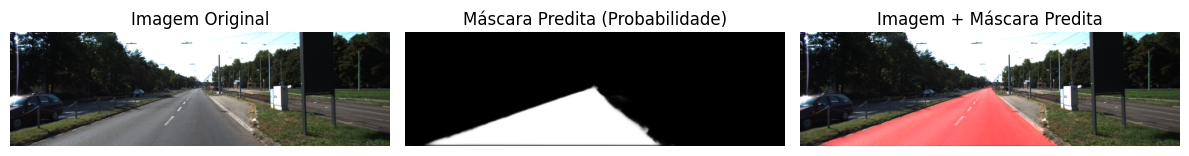

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


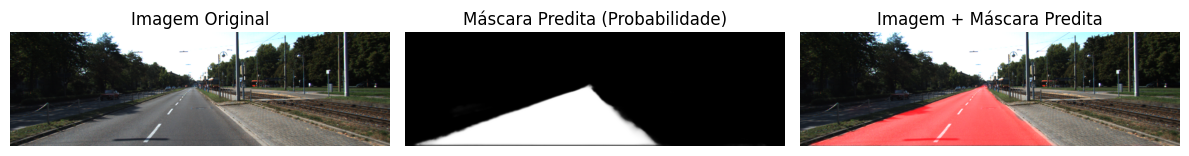

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


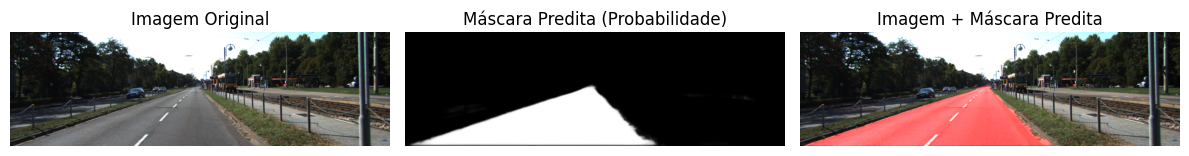

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


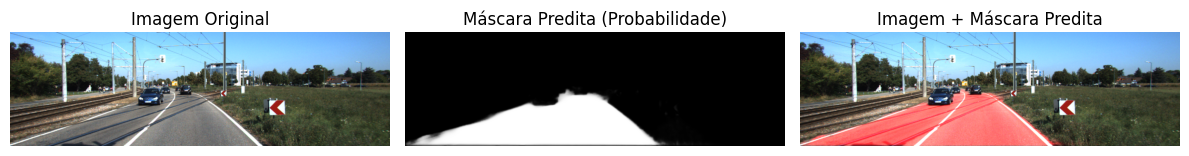

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


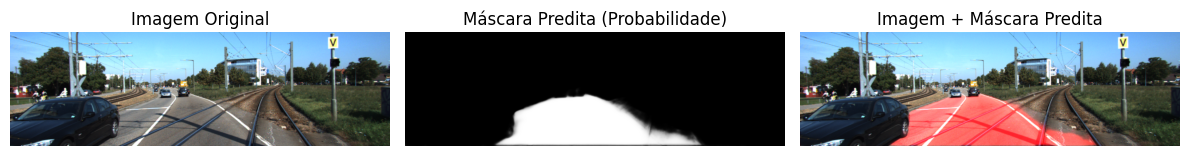

In [20]:
show_predictions(model, test_images, num=5)


  0%|          | 0/57 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


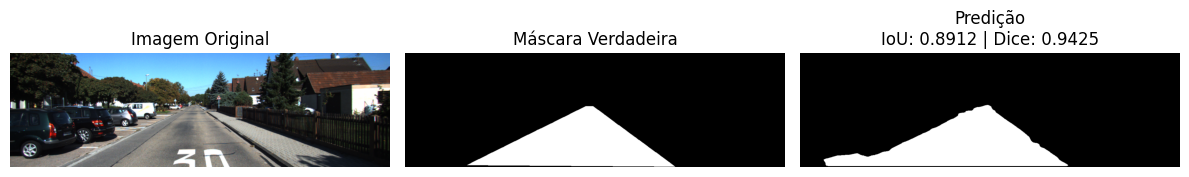

  2%|▏         | 1/57 [00:00<00:25,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


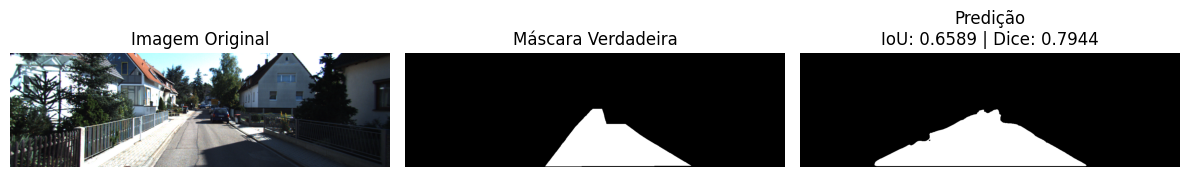

  4%|▎         | 2/57 [00:00<00:23,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


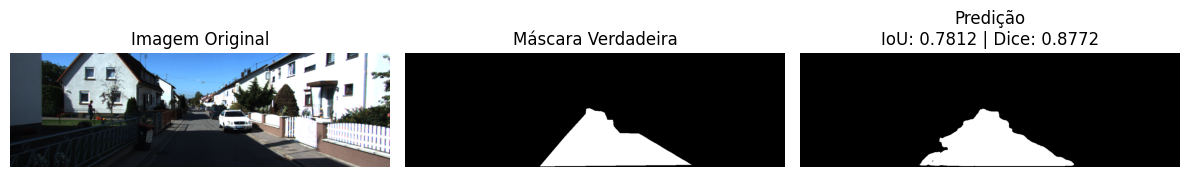

  5%|▌         | 3/57 [00:01<00:23,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


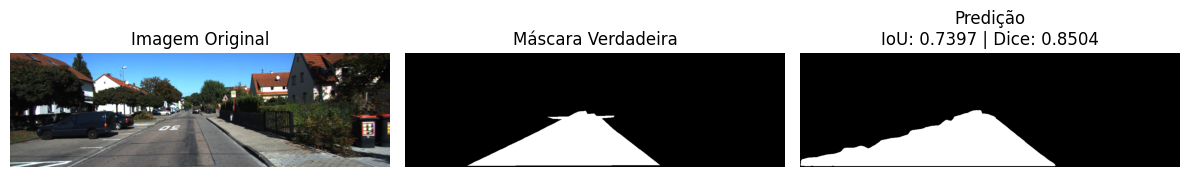

  7%|▋         | 4/57 [00:01<00:22,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


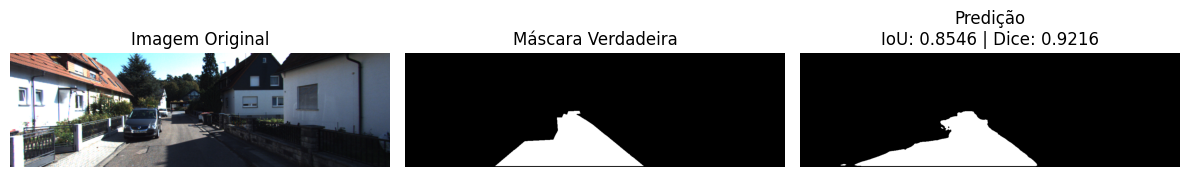

  9%|▉         | 5/57 [00:02<00:22,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 11%|█         | 6/57 [00:02<00:16,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 12%|█▏        | 7/57 [00:02<00:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 14%|█▍        | 8/57 [00:02<00:11,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 16%|█▌        | 9/57 [00:02<00:09,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 18%|█▊        | 10/57 [00:02<00:08,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 19%|█▉        | 11/57 [00:02<00:07,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 21%|██        | 12/57 [00:03<00:06,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 23%|██▎       | 13/57 [00:03<00:06,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 25%|██▍       | 14/57 [00:03<00:06,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 26%|██▋       | 15/57 [00:03<00:05,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 28%|██▊       | 16/57 [00:03<00:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 30%|██▉       | 17/57 [00:03<00:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 32%|███▏      | 18/57 [00:03<00:05,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 33%|███▎      | 19/57 [00:04<00:05,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 35%|███▌      | 20/57 [00:04<00:04,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 37%|███▋      | 21/57 [00:04<00:04,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 39%|███▊      | 22/57 [00:04<00:04,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 40%|████      | 23/57 [00:04<00:04,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 42%|████▏     | 24/57 [00:04<00:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 44%|████▍     | 25/57 [00:04<00:04,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 46%|████▌     | 26/57 [00:04<00:04,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 47%|████▋     | 27/57 [00:05<00:04,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 49%|████▉     | 28/57 [00:05<00:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 29/57 [00:05<00:03,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 30/57 [00:05<00:03,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 31/57 [00:05<00:03,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 56%|█████▌    | 32/57 [00:05<00:03,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 58%|█████▊    | 33/57 [00:05<00:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|█████▉    | 34/57 [00:06<00:03,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 61%|██████▏   | 35/57 [00:06<00:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 63%|██████▎   | 36/57 [00:06<00:02,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 65%|██████▍   | 37/57 [00:06<00:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 67%|██████▋   | 38/57 [00:06<00:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 68%|██████▊   | 39/57 [00:06<00:02,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 70%|███████   | 40/57 [00:06<00:02,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 72%|███████▏  | 41/57 [00:06<00:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 74%|███████▎  | 42/57 [00:07<00:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▌  | 43/57 [00:07<00:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 44/57 [00:07<00:01,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 79%|███████▉  | 45/57 [00:07<00:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 81%|████████  | 46/57 [00:07<00:01,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 82%|████████▏ | 47/57 [00:07<00:01,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 48/57 [00:07<00:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 86%|████████▌ | 49/57 [00:08<00:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 88%|████████▊ | 50/57 [00:08<00:00,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 51/57 [00:08<00:00,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 52/57 [00:08<00:00,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 53/57 [00:08<00:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 95%|█████████▍| 54/57 [00:08<00:00,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▋| 55/57 [00:08<00:00,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 98%|█████████▊| 56/57 [00:08<00:00,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


100%|██████████| 57/57 [00:09<00:00,  6.27it/s]


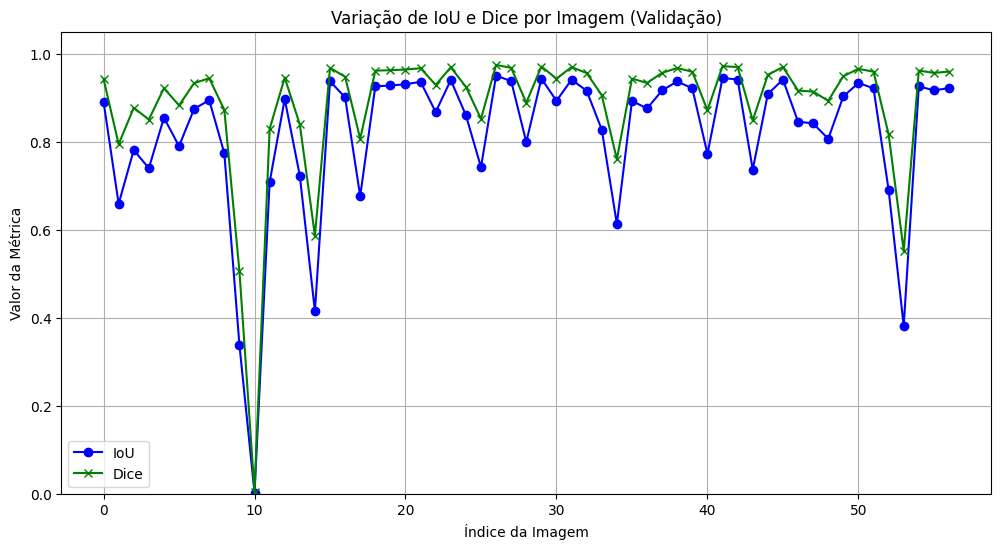


📈 IoU médio no conjunto de validação: 0.8190
🎯 Dice Coefficient médio: 0.8860


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# === Funções de Métricas ===

def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

def compute_dice(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    if total == 0:
        return 1.0 if intersection == 0 else 0.0
    return 2. * intersection / total

# === Processamento e Visualização ===

ious = []
dices = []

num_visual = 5  # número de imagens que você quer visualizar

for idx, img_name in tqdm(enumerate(valid_images), total=len(valid_images)):
    img_path = os.path.join(image_data_folder, img_name)
    mask_path = os.path.join(mask_data_folder, all_mask_images[img_name])

    # Carregar imagem
    original_img = load_img(img_path)
    image = img_to_array(original_img)
    image = cv2.resize(image, (width, height)) / 255.0

    # Carregar máscara verdadeira
    mask = load_img(mask_path)
    mask = img_to_array(mask)
    mask = cv2.resize(mask, (width, height))
    true_mask = (mask[:, :, 2] > 127).astype(np.uint8)

    # Predição
    pred = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    # Métricas
    iou = compute_iou(true_mask, pred)
    dice = compute_dice(true_mask, pred)

    ious.append(iou)
    dices.append(dice)

    # Mostrar as primeiras N imagens
    if idx < num_visual:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow((image * 255).astype(np.uint8))
        plt.title("Imagem Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Máscara Verdadeira")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predição\nIoU: {iou:.4f} | Dice: {dice:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# === Gráfico das métricas por imagem ===

plt.figure(figsize=(12, 6))
plt.plot(ious, label='IoU', marker='o', color='blue')
plt.plot(dices, label='Dice', marker='x', color='green')
plt.title('Variação de IoU e Dice por Imagem (Validação)')
plt.xlabel('Índice da Imagem')
plt.ylabel('Valor da Métrica')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

# Média geral
print(f"\n📈 IoU médio no conjunto de validação: {np.mean(ious):.4f}")
print(f"🎯 Dice Coefficient médio: {np.mean(dices):.4f}")
